# Implementation of the SiPM response functions

This repository attempts to implement the SiPM low light response functions
described in [arXiv:1609.01181][sipm_response] in a python library to allow for interfacing with the broader data analysis tools used by HEP. In this
notebook we will mainly break down the mathematical components that go into the
description given in the paper. And these functions are implemented in the
`sipmpdf.functions` module.

[sipm_response]: https://arxiv.org/pdf/1609.01181.pdf


In [1]:
import sipmpdf
import sipmpdf.pdf as PDF
import matplotlib.pyplot as plt
import numpy as np
import mplhep
from scipy.stats import rv_discrete
import zfit
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

/srv/.env/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
pedestal = zfit.Parameter('pedestal value', 5.0, -10, 50)
gain = zfit.Parameter('gain', 150.0, 100, 200)
common_noise = zfit.Parameter('common_noise', 15.0, 5, 25)
pixel_noise = zfit.Parameter('pixel_noise', 2.0, 1, 3)
poisson_mean = zfit.Parameter('poisson_mean', 2.5, 2, 3)
poisson_borel = zfit.Parameter('poisson_borel', 0.0, 0, 0.1)
ap_beta=zfit.Parameter('ap_beta',100,20,120)
ap_prob=zfit.Parameter('ap_prob',.1,.05,.2)
dc_prob=zfit.Parameter('dc_prob', .1,.01,.3)
dc_res =zfit.Parameter('dc_res', 10e-4,0,1)
obs = zfit.Space('x', limits=(-200, +1500))

## The generalized Poisson distribution

The [Generalized Poisson distribution][gen_poisson] $GP(x;\mu,\lambda)$ is used
to model the deviation from a simple Poisson distribution due to in-time
correlated discharges driven by optical crosstalk within the SiPM.

$$
GP(k;\mu\lambda) = \frac{\mu(\mu + \lambda x)^{k-1}}{k!}\exp(-(\mu+\lambda x))
$$

This function is implemented as `sipmpdf.functions.generalized_poisson`.

[gen_poisson]: https://www.jstor.org/stable/1267389


Text(0, 0.5, 'Probablity')

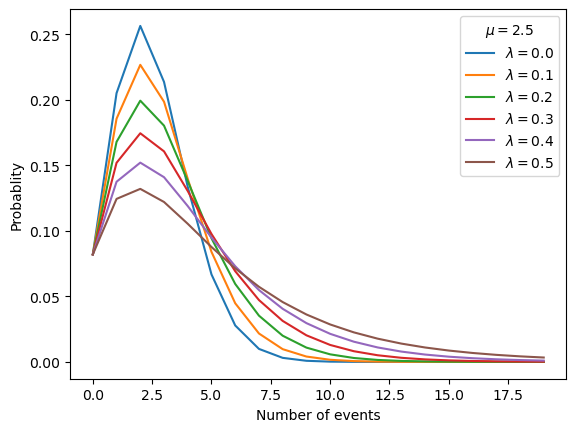

In [3]:
n = np.arange(20)
mu = 2.5

for idx, borel in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]):
  plt.plot(n,
           sipmpdf.functions.generalized_poisson(n, mu, borel),
           color=COLORS[idx],
           label=f'$\lambda={borel}$')
plt.legend(title='$\mu=2.5$')
plt.xlabel('Number of events')
plt.ylabel('Probablity')

## A Gaussian smeared General Poisson distribution

Here we provide a model that excludes other nonlinear effects other than cross
talk. This is given by the convolution of the General Poisson distribution
smeared by a Gaussian noise. The PDF of this model is given as: 

$$
P(x;p, g, \mu, \lambda, \sigma_0, \sigma_1) = 
\sum_{n=0}^{\infty} GP(n;\mu,\lambda) \cdot  
N(x; p + ng, \sqrt{\sigma_0^2 + p\sigma_1^2})
$$

Where $GP$ is the general poisson distribution (shown previously), and
$N(x;m,\sigma)$ is the Gaussian distribution a mean value $m$ and standard
deviation $\sigma$. 

[-100.          -99.49974987  -98.99949975 ...  898.99949975  899.49974987
  900.        ] [4.87634153e-13 6.08710458e-13 7.59004548e-13 ... 1.12990136e-03
 1.13160600e-03 1.13217479e-03]


Text(30, 0.0005927525971697381, '')

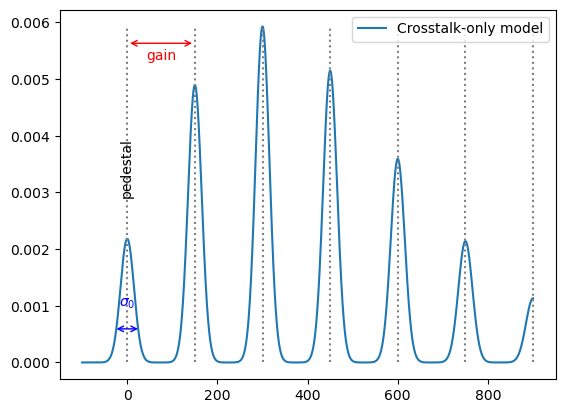

In [4]:
x = np.linspace(-100, 900, 2000)
y = sipmpdf.functions.sipm_response_no_dark_no_ap(x,
                                             pedestal=0,
                                             gain=150,
                                             common_noise=15,
                                             pixel_noise=2,
                                             poisson_mean=2.5,
                                             poisson_borel=0.1)
print(x, y)
plt.plot(x, y, label=f'Crosstalk-only model')
ymax = np.max(y)
plt.legend()
plt.vlines(150 * np.arange(7),
           ymin=0,
           ymax=np.max(y),
           color='gray',
           linestyles='dotted')
plt.annotate('pedestal', [0, ymax * 0.5], rotation=90, ha='center')
plt.annotate('gain', [75, ymax * 0.9], ha='center', color='red')
plt.annotate('',
             xy=(0, ymax * 0.95),
             xytext=(150, ymax * 0.95),
             arrowprops=dict(arrowstyle='<->', color='red'))

plt.annotate('$\sigma_0$', [0, 0.001], ha='center', color='blue')
plt.annotate('',
             xy=(-30, ymax * 0.1),
             xytext=(30, ymax * 0.1),
             arrowprops=dict(arrowstyle='<->', color='blue'))


Though this will not be officially supported, the user can implement a simple
z-fit PDF to use this model. We are going to give a stand along example here, as
the full response function is even more expensive to compute. Notice since the
evaluation of functions is expensive, users should attempt to use a binned fit
where ever possible. Here we first declare the objects required for the fit:

In [5]:
# Simple declaration of the zfit PDF
class DemoSiPMPDF(zfit.pdf.ZPDF):
  _N_OBS = 1
  _PARAMS = [
    'pedestal', 'gain', 'common_noise', 'pixel_noise', 'poisson_mean',
    'poisson_borel'
  ]

  def _unnormalized_pdf(self, x):
    x = zfit.z.unstack_x(x)
    return sipmpdf.functions.sipm_response_no_dark_no_ap(
      x, **{k: self.params[k]
            for k in self._PARAMS})

# Declaring the "unbinned" PDF
pdf = DemoSiPMPDF(obs=obs,
                  pedestal=pedestal,
                  gain=gain,
                  common_noise=common_noise,
                  pixel_noise=pixel_noise,
                  poisson_mean=poisson_mean,
                  poisson_borel=poisson_borel)

# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1800, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)


Then we can generate pseudo data using the random number generation provided in
numpy.


In [6]:
#define generalized poisson distribution random variable generator
class GeneralPoissonRNG(rv_discrete):
    "Generalized Poisson distribution"
    def _pmf(self, k, mu, lam):
        return sipmpdf.functions.generalized_poisson(k=k,mean=mu,borel=lam)
gen_poisson_rng = GeneralPoissonRNG()

# Number of discharges following the regular Poisson distribution
n_pe = gen_poisson_rng.rvs(mu=2.5,lam=.01, size=100_000)
# For each discharge there is a set random uncertainty
noise = np.sqrt(15.0**2 + n_pe * 2.0**2)
# We run a second smearing using the random normal distribution
data_array = np.random.normal(size=100_000, loc=n_pe * 150 + 5, scale=noise)

# First we construct the unbinned data
data_unbinned = zfit.Data.from_numpy(obs=obs, array=data_array)
# Then the binned data
data_bin = data_unbinned.to_binned(obs_bin)


Next we can run the minizer:

In [7]:
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.sum. Make sure the functionality has been implemented!
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1180: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f1cbc1487f0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f1cbc0bfa60>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00024 │ 823.7419    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)        hesse    at limit
--------------  ------------------  -----------  ----------
pedestal value             4.86938  +/-    0.09       False
gain                       150.016  +/-   0.031       False
common_noise               15.0646  +/-   0.065       False
pixel_noise                1.82896  +/-    0.18       False
poisson_mean               2.49532  +/-  0.0075       False
poi

We can also invoke the various facility to plot the fit results:

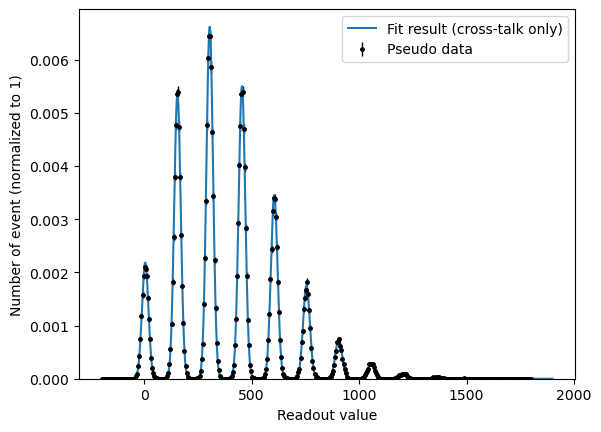

In [8]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result (cross-talk only)')
plt.xlabel('Readout value')
plt.ylabel('Number of event (normalized to 1)')
plt.legend()


## Afterpulse response

For $k$ pixels undergoing primary discharges, each discharged pixel has a probability $P_{a.p}$ of undergoing afterpulsing. The contribution of afterpulsing to the readout is modeled using a simple exponential model extending above the primary discharge, with the afterpulse factor $\beta$:

$$A_{a.p.}(x;n_{a,p}=1,\beta)=\frac{1}{\beta}exp\left(-\frac{x}{\beta}\right); \quad (x>0)$$

Note: The source paper for these equations uses $i$ in place of $n_{a.p.}$. We used the second option for improved readability

Here $x$ is the additional contribution of the afterpulse above the primary discharge. Contributions from multiple afterpulses can also be modelled by the analytic convolution of the multiple exponential distributions:

$$A_{a.p.}(x;n_{a.p.},\beta)=\otimes_1^{n_{a.p.}}A_{a.p.}(x;n_{a.p.}=1,\beta)=\frac{x^{(n_{a.p.}-1)}}{(n_{a.p.}-1)!\beta^{n_{a.p.}}}*exp\left(-\frac{x}{\beta}\right); \quad (x>0)$$

While the total contribution of the primary discharge and the variable afterpulsing should be subject to noise and gain variations in the system, $A(x;n_{a.p.},\beta,\sigma)$, the convolution of the exponential distribution with a normal distribution, does not have a simple analytic form. Instead, for multiple afterpulse contributions, we work under the assumption that the exponential factor $\beta$ of the afterpulse is generally larger than the noise factor $\sigma_0$. For number of afterpulses $n_{a.p.}>1$ the afterpulse contribution distribution is sufficiently smooth such that additional convolution with the noise factor is not needed i.e. $A(x;n_{a.p.}>1,\beta,\sigma)\sim A(x;n_{a.p.}>1,\beta)$. 

For $n_{a.p.}=1$, we use the approximation:

$$A_{a.p.}(x;n_{a.p.}=1,\beta,\sigma)=A_{a.p.}(x;n_{a.p.}=1,\beta) \otimes G(x;\sigma) \sim \frac{1}{2\beta} exp\left(-\frac{x}{\beta}\right)\left(1+erf\left(\frac{x}{\sigma_k \sqrt{2}}
\right)\right)$$

The following plot is an example of afterpulsing contributions with various values of $n_{a.p.}$.



/srv/.env/lib/python3.8/site-packages/sipmpdf/functions.py:224: RuntimeWarning: invalid value encountered in log
  kern.log(kern.power(x, n_ap - 1)) - kern.log(kern.power(beta, n_ap)) -


Text(0.5, 1.0, 'Afterpulse Response for Fixed Photoelectrons and Afterpulses')

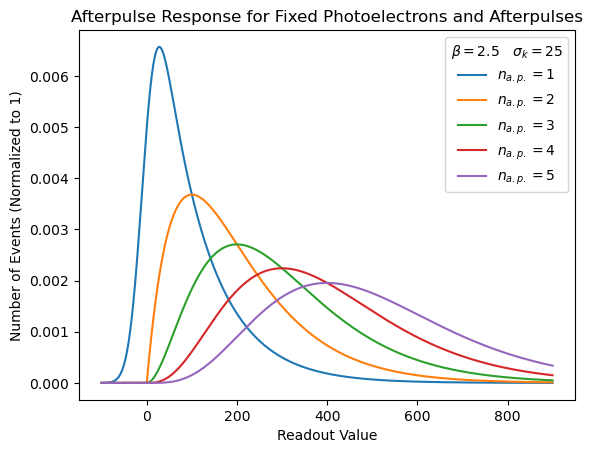

In [9]:
x = np.linspace(-100, 900, 2000)

single_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                       smear=25,
                                       n_ap=1,
                                       beta=100)

two_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                                     smear=25,
                                                     n_ap=2,
                                                     beta=100)
three_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                                       smear=25,
                                                       n_ap=3,
                                                       beta=100)
four_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                                       smear=25,
                                                       n_ap=4,
                                                       beta=100)
five_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                                       smear=25,
                                                       n_ap=5,
                                                       beta=100)
plt.plot(x, single_ap_response, label=r'$n_{a.p.}=1$')
plt.plot(x, two_ap_response, label=r'$n_{a.p.}=2$')
plt.plot(x, three_ap_response, label=r'$n_{a.p.}=3$')
plt.plot(x, four_ap_response, label=r'$n_{a.p.}=4$')
plt.plot(x, five_ap_response, label=r'$n_{a.p.}=5$')

plt.legend(title=r'$\beta=2.5\quad\sigma_k=25$')
plt.xlabel('Readout Value')
plt.ylabel('Number of Events (Normalized to 1)')
plt.title('Afterpulse Response for Fixed Photoelectrons and Afterpulses')


The impact of afterpulsing on the readout spectrum is that the primary discharge peak has additional non-Gaussian smearing from probabilistic contributions from afterpulsing. The degree by which this smearing occurs also depends on the number of primary discharges that occur, as that also determines the number of afterpulses that can ocur. The function form of this smearing can be analytically expressed using the Binomial probability of $n_{a.p.}$ occuring given $k$ primary discharges $B(n_{a.p.};k,P_{a.p.})$.

$$B(0;k,P_{a.p.})G(x-kg,\sigma_k)+\sum_{n_{a.p.}=1}^k B(n_{a.p.};k,P_{a.p.})A(x-kg;n_{a.p.},\beta,\sigma_k)$$

An example of different degrees of non-Gaussian smearing caused by afterpulsing for different numbers of primary discharges is shown below.

Text(0.5, 1.0, 'Total Afterpulse Response for Fixed Number of Photoelectrons')

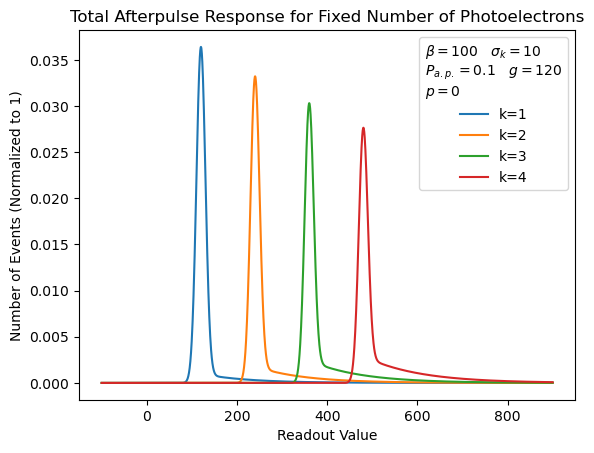

In [30]:
x = np.linspace(-100, 900, 2000)
ap_beta_=100
ap_prob_=.1
pedestal_=0
gain_=120
sigma_k_=10

sum_ap_response_1=sipmpdf.functions._full_afterpulse_response(x=x,ap_beta=ap_beta_,ap_prob=ap_prob_,total=1,pedestal=pedestal_,gain=gain_,sigma_k=sigma_k_)
sum_ap_response_2=sipmpdf.functions._full_afterpulse_response(x=x,ap_beta=ap_beta_,ap_prob=ap_prob_,total=2,pedestal=pedestal_,gain=gain_,sigma_k=sigma_k_)
sum_ap_response_3=sipmpdf.functions._full_afterpulse_response(x=x,ap_beta=ap_beta_,ap_prob=ap_prob_,total=3,pedestal=pedestal_,gain=gain_,sigma_k=sigma_k_)
sum_ap_response_4=sipmpdf.functions._full_afterpulse_response(x=x,ap_beta=ap_beta_,ap_prob=ap_prob_,total=4,pedestal=pedestal_,gain=gain_,sigma_k=sigma_k_)

plt.plot(x,sum_ap_response_1, label=f'k=1')
plt.plot(x,sum_ap_response_2, label=f'k=2')
plt.plot(x,sum_ap_response_3, label=f'k=3')
plt.plot(x,sum_ap_response_4, label=f'k=4')
#plt.legend(title=r'$\beta=$'f'{ap_beta_}' \quad \sigma_k=10$' '\n' '$P_{a.p}=.1 \quad g=120$' '\n' '$p=0$')
plt.legend(title=r'$\beta=$'f'{ap_beta_}'r'$\quad \sigma_k=$'f'{sigma_k_} \n'r'$P_{a.p.}=$'f'{ap_prob_}'r'$\quad g=$'f'{gain_} \n'r'$p=$'f'{pedestal_}')
plt.xlabel('Readout Value')
plt.ylabel('Number of Events (Normalized to 1)')
plt.title('Total Afterpulse Response for Fixed Number of Photoelectrons')

Putting this together with the General poisson distribution for the number of the primary discharges that can occur, we arrive at another semi-realistic response model.

## SiPM Response Model Excluding Dark Noise

$$GP(0;\mu,\lambda)G(x;p,\sigma_0)+ \sum_{k=1}GP(k;\mu,\lambda) \left( B(0;k,P_{a.p.})G(x;p+kg,\sigma_k)+\sum_{n_{a.p.}=1}^{10} B(n_{a.p.};k,P_{a.p.})A(x;n_{a.p.},k,\beta)\right) $$

In [31]:
#Create pdf for the response with no dark current
pdf = PDF.SiPMResponse_NoDC_PDF(obs=obs,
                  pedestal=pedestal,
                  gain=gain,
                  ap_beta=ap_beta,
                  ap_prob=ap_prob,
                  common_noise=common_noise,
                  pixel_noise=pixel_noise,
                  poisson_mean=poisson_mean,
                  poisson_borel=poisson_borel)
# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1800, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

In [12]:
#Create pseudodata for the response with no dark current
N_EVENTS = 1_000_000


gain_ = 120.
mu_ = 2.5 
beta_ = 120
prob_ap_ = 0.05
s0_ = 15.
s1_ = 2.
lam_ =.01

k = gen_poisson_rng.rvs(mu=mu_,lam=lam_, size=N_EVENTS) # Number of primary discharges

ap_shape = (N_EVENTS,10) # Up to 10 afterpulses per event

# Single ap discharge response
ap = np.random.exponential(beta_, size=ap_shape) 
# Discarding AP responses if number of AP exceeds number of primary discharges 
ap = np.where( k[:,np.newaxis] > np.indices(ap_shape)[1], 0, ap ) 
# AP only has finite chance of appearing
ap = np.where(np.random.random(size=ap_shape) > prob_ap_, 0, ap)

#Constructing the response with no random smearing
response = k * gain_ + np.sum(ap,axis=-1)

#Add in gaussian smearing
response+=np.random.normal(loc=0,scale=np.sqrt(s0_**2+k*s1_**2),size=N_EVENTS)

data_array=response

In [13]:
# First we construct the unbinned data
data_unbinned = zfit.Data.from_numpy(obs=obs, array=data_array)
# Then the binned data
data_bin = data_unbinned.to_binned(obs_bin)

nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.power. Make sure the functionality has been implemented!
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.sum. Make sure the functionality has been implemented!
  warnings.warn(


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f1c7a700dc0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f1c7a75ddf0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ False   │ True        │ True             │ 0.00026 │ 13785.65    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)        hesse    at limit
--------------  ------------------  -----------  ----------
pedestal value              2.9917  +/-   0.046       False
gain                       118.671  +/-   0.018       False
common_noise               18.1525  +/-   0.027       False
pixel_noise                      1  +/- 1.6e-05        True
poisson_mean               2.76566  +/-  0.0027       False
poi

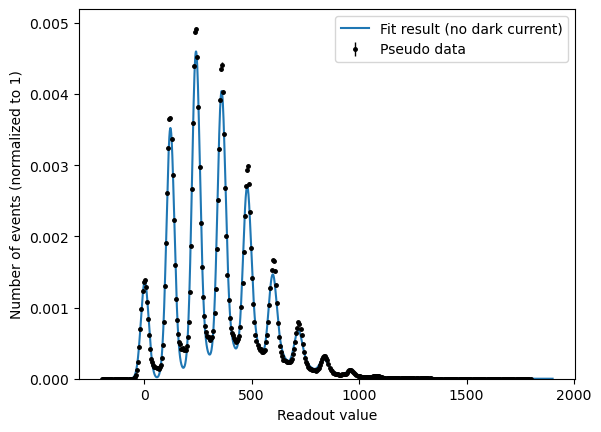

In [14]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result (no dark current)')
plt.xlabel('Readout value')
plt.ylabel('Number of events (normalized to 1)')
plt.legend()

## Dark Current Response
Dark current is temporarily uncorrelated discharges wandering into the data collection window. The model of this is evaluated in the paper as: 

$$ D(x)=\frac{1}{2*log(\frac{g}{\epsilon})}\left(\frac{1}{x-p}+\frac{1}{p+g-x} \right)$$

Where $\epsilon$ is the resolution factor of the data collection relative to the discharge peak shape. A numerical convolution of this function is used with a normal distribution to account for electrical noise. (Given the sharp features of $D(x)$, the limitations of numerical convolution are why the function appears "noisy")

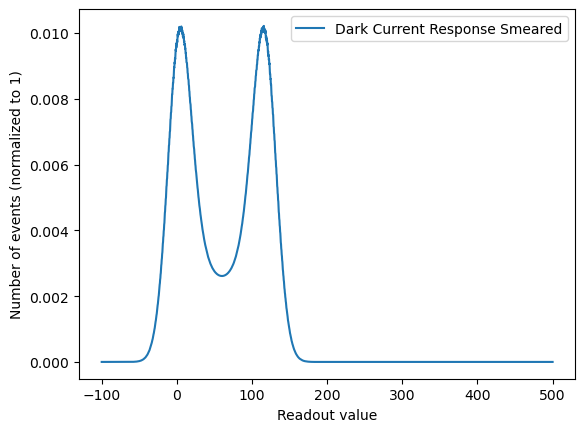

In [15]:
x = np.linspace(-100, 500,2000)
gain_=120
smear_=15
resolution_=10e-4
dc=sipmpdf.functions.darkcurrent_response_smeared(x=,smear=15,gain=120,resolution=10e-4)

plt.plot(x,dc,label="Dark Current Response Smeared")
plt.xlabel('Readout value')
plt.ylabel('Number of events (normalized to 1)')
plt.legend(f'g')

Adding dark current contributions to events where there were no time-correlated discharges, we arrive at the full model of the SiPM Response:

## Full SiPM Response Model

$$GP(0;\mu,\lambda)*\left((1-P_{d.c.})G(x;p,\sigma_0)+P_{d.c.}D_{smeared}(x)\right)+ \sum_{k=1}GP(k;\mu,\lambda) \left( B(0;k,P_{a.p.})G(x;p+kg,\sigma_k)+\sum_{n_{a.p.}=1}^{10} B(n_{a.p.};k,P_{a.p.})A(x;n_{a.p.},k,\beta)\right) $$

In [16]:
#Create pdf for the full response
pdf = PDF.SiPMResponsePDF(obs=obs,
                  pedestal=pedestal,
                  gain=gain,
                  ap_beta=ap_beta,
                  ap_prob=ap_prob,
                  common_noise=common_noise,
                  pixel_noise=pixel_noise,
                  poisson_mean=poisson_mean,
                  poisson_borel=poisson_borel,
                  dc_prob=dc_prob,
                  dc_res=dc_res)
# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1800, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

In [17]:
# Create pseudodata
N_EVENTS = 100_000

gain_ = 120.
mu_ = 2.5 
beta_ = 120
prob_ap_ = 0.05
prob_dc_ = .05
lam_ =.01
s0_ = 15.
s1_ = 3.

k = gen_poisson_rng.rvs(mu=mu_,lam=lam_, size=N_EVENTS) # Number of primary discharges

ap_shape = (N_EVENTS,15) # Up to 10 after pulses per event

# Single ap discharge response
ap = np.random.exponential(beta_, size=ap_shape) 
# Discarding AP responses if number of AP exceeds number of primary discharges 
ap = np.where( k[:,np.newaxis] > np.indices(ap_shape)[1], 0, ap ) 
# AP only has finite chance of appearing
ap = np.where(np.random.random(size=ap_shape) > prob_ap_, 0, ap)

# Constructing the response with no random smearing
response = k * gain_ + np.sum(ap,axis=-1)

# Insert gaussian smearing
response+=np.random.normal(loc=0,scale=np.sqrt(s0_**2 + k*s1_**2),size=N_EVENTS)

# Create dark current data, Integration window starting time relative to random discharge
# In units of sipm pulse time constant
tgate = 3
t = np.random.uniform(-tgate,tgate, size=N_EVENTS) 

# Getting the integration results (assuming integration window width of tgate)
neg = np.exp(t)*(1-np.exp(-tgate))
pos = np.where(t>=tgate,0,1 - np.exp(-(tgate-t)))
dark_resp = np.where(t < 0, neg, pos) * gain

# Inject random noise into dark current response
dark_resp = dark_resp + np.random.normal(loc=0, scale=10, size=N_EVENTS)

# replace some k=0 values with dark current values
random_arr=np.random.rand(N_EVENTS)
random_arr=np.where(k==0,random_arr,2)
response=np.where(random_arr<prob_dc_,dark_resp,response)

data_array=response

In [18]:
# First we construct the unbinned data
data_unbinned = zfit.Data.from_numpy(obs=obs, array=data_array)
# Then the binned data
data_bin = data_unbinned.to_binned(obs_bin)

#Fit the equation to the data
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.sum. Make sure the functionality has been implemented!
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.power. Make sure the functionality has been implemented!
  warnings.warn(


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f1c7ab82eb0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f1c7ad52d00>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm    │ min value   │
╞═════════╪═════════════╪══════════════════╪════════╪═════════════╡
│ False   │ True        │ True             │ 0.0018 │ 1958.76     │
╘═════════╧═════════════╧══════════════════╧════════╧═════════════╛

Parameters
name              value  (rounded)        hesse    at limit
--------------  ------------------  -----------  ----------
pedestal value             2.78277  +/-   0.063       False
gain                       118.363  +/-  0.0027       False
common_noise               18.1282  +/- 0.00031       False
pixel_noise                1.00009  +/-  0.0045       False
poisson_mean               2.66757  +/-  0.0046       False
poisson_

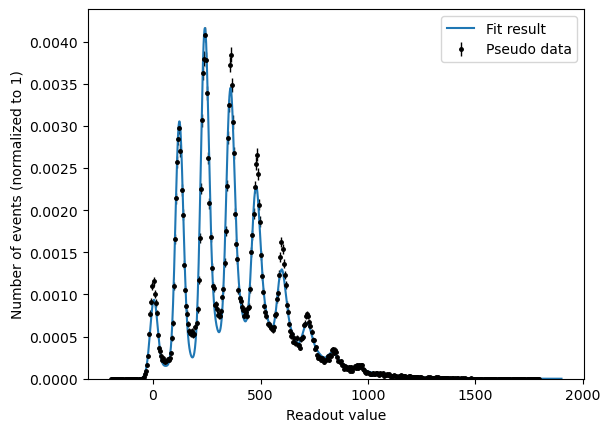

In [19]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result')
plt.xlabel('Readout value')
plt.ylabel('Number of events (normalized to 1)')
plt.legend()